##Git Clone
Clone the github repository to be able to access the dataset as it is uploaded to the repository

In [2]:
!git clone https://github.com/KaleF07/WasteClassification.git

Cloning into 'WasteClassification'...
remote: Enumerating objects: 24835, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 24835 (delta 22), reused 56 (delta 22), pack-reused 24779
Receiving objects: 100% (24835/24835), 392.58 MiB | 35.81 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Updating files: 100% (50163/50163), done.


##IMPORTS

In [116]:
!pip install tensorflow-model-optimization

import os
from fastai.vision.widgets import *
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras import datasets, layers, models, Model
import matplotlib.pyplot as plt
import time
import tempfile
import numpy as np
from fastai.vision.all import Learner
import tensorflow_model_optimization as tfmot
from tensorflow import keras
from tqdm.notebook import trange, tqdm
import zipfile
import pandas as pd

##DATA LOADING & AUGMENTATION

In [56]:
from keras.preprocessing.image import ImageDataGenerator

# Step 2: Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images by 20 degrees
    width_shift_range=0.1,  # randomly shift images horizontally by 10%
    height_shift_range=0.1,  # randomly shift images vertically by 10%
    zoom_range=0.1,  # randomly zoom into images by 10%
    brightness_range=[0.5, 1.5],  # randomly adjust brightness between 0.5 and 1.5
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True,  # randomly flip images vertically
    rescale=1./255  # rescale pixel values to the range [0, 1]
)

# Step 3: Load data
train_generator = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TRAIN',  # path to the training data directory
    target_size=(150, 150),  # resize images to 150x150
    batch_size=32,  # batch size
    class_mode='binary'  # binary classification
)

validation_generator = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TEST',  # path to the validation data directory
    target_size=(150, 150),  # resize images to 150x150
    batch_size=32,  # batch size
    class_mode='binary'  # binary classification
)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


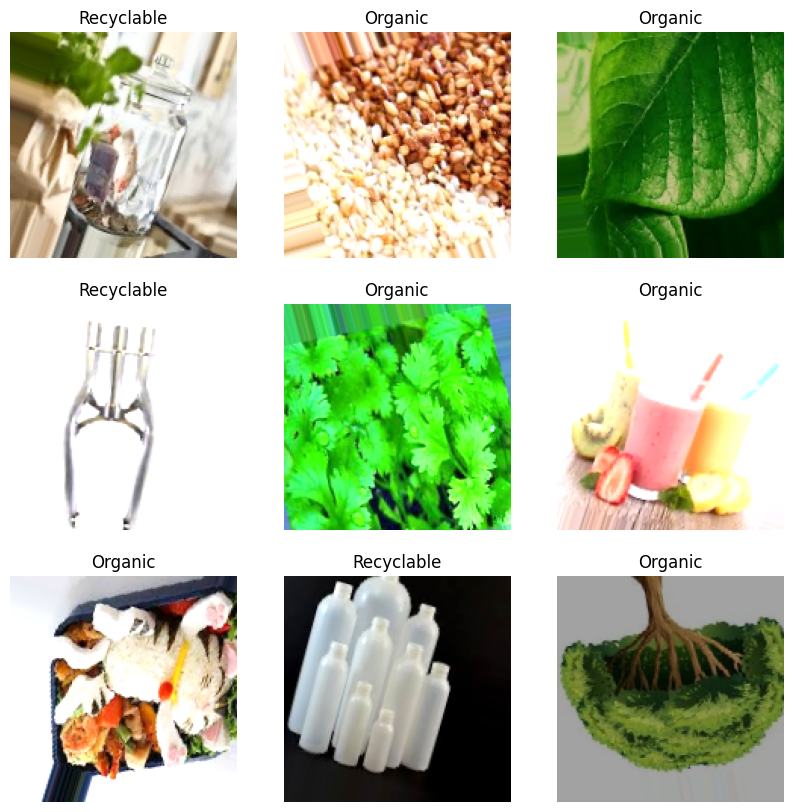

In [5]:
# Get a batch of images and labels from the generator
batch_images, batch_labels = next(train_generator)  # or validation_generator

# Define class names
class_names = ['Organic', 'Recyclable']

# Display the first few images with their labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch_images[i])
    plt.title('{}'.format(class_names[int(batch_labels[i])]))
    plt.axis('off')
plt.show()

In [6]:
# Load MobileNet model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with 128 neurons
x = Dense(128, activation='relu')(x)

# Add a classification layer with the number of classes in your dataset
predictions = Dense(2, activation='softmax')(x)

# Combine the base model with the new layers
base_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
base_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
base_model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
base_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = base_model.fit_generator(
    train_generator,  # training data generator
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,  # validation data generator
    validation_steps=len(validation_generator)
)

<ipython-input-29-746f62817607>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mobilemodel.fit_generator(


Epoch 1/10
706/706 [==============================] - 148s 188ms/step - loss: 0.4499 - accuracy: 0.8082 - val_loss: 0.3925 - val_accuracy: 0.8468
Epoch 2/10
706/706 [==============================] - 133s 188ms/step - loss: 0.3793 - accuracy: 0.8431 - val_loss: 0.3951 - val_accuracy: 0.8635
Epoch 3/10
706/706 [==============================] - 132s 187ms/step - loss: 0.3522 - accuracy: 0.8540 - val_loss: 0.7421 - val_accuracy: 0.7823
Epoch 4/10
706/706 [==============================] - 134s 190ms/step - loss: 0.3306 - accuracy: 0.8646 - val_loss: 0.5101 - val_accuracy: 0.8201
Epoch 5/10
706/706 [==============================] - 133s 188ms/step - loss: 0.3325 - accuracy: 0.8614 - val_loss: 0.3284 - val_accuracy: 0.8762
Epoch 6/10
706/706 [==============================] - 133s 189ms/step - loss: 0.3199 - accuracy: 0.8682 - val_loss: 0.3918 - val_accuracy: 0.8492
Epoch 7/10
706/706 [==============================] - 133s 189ms/step - loss: 0.3065 - accuracy: 0.8748 - val_loss: 0.2568 -

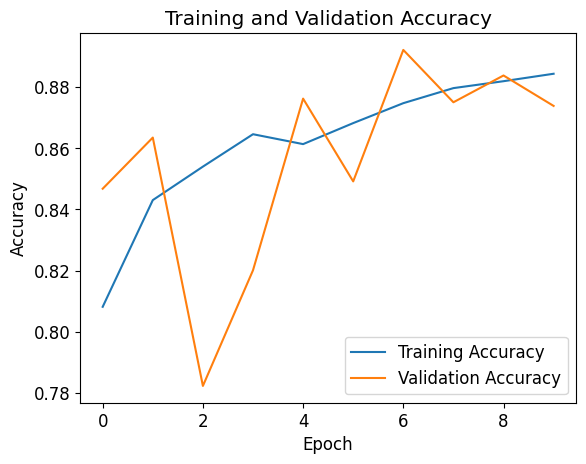

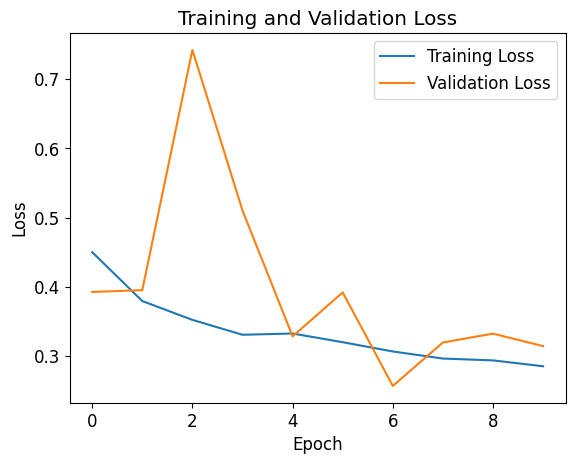

In [ ]:
# Extract accuracy and loss from the history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model to disk
base_model.save('mobilenet_model.h5')

# Check the file size
import os
print("Model size:", os.path.getsize('mobilenet_model.h5'), "bytes")

import time

# Measure inference time
start_time = time.time()
predictions = base_model.predict(validation_generator)
end_time = time.time()

# Calculate average inference time per sample
inference_time_per_sample = (end_time - start_time) / len(validation_generator)

print("Inference time per sample:", inference_time_per_sample, "seconds")

Model size: 40618784 bytes
79/79 [==============================] - 13s 168ms/step
Inference time per sample: 0.1720262599896781 seconds


In [ ]:
def residual_block(x, filters, kernel_size=3, strides=1, activation='relu'):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)

    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)

    if strides != 1 or x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    out = layers.Add()([x, y])
    out = layers.Activation(activation)(out)
    return out

def ResNet(input_shape=(32, 32, 3), num_classes=10, num_blocks_list=[3, 4, 6, 3], base_filters=64):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(base_filters, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for i, num_blocks in enumerate(num_blocks_list):
        filters = base_filters * (2**i)
        strides = 1 if i == 0 else 2

        for _ in range(num_blocks):
            x = residual_block(x, filters=filters, strides=strides)
            strides = 1

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
resnet_model = ResNet(input_shape=(150, 150, 3), num_classes=2, num_blocks_list=[4, 5, 6, 4], base_filters=64)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
resnet_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = resnet_model.fit_generator(
    train_generator,  # training data generator
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,  # validation data generator
    validation_steps=len(validation_generator)
)

<ipython-input-37-84dcab81621a>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = resnet_model.fit_generator(


Epoch 1/10
706/706 [==============================] - 160s 192ms/step - loss: 0.5402 - accuracy: 0.7894 - val_loss: 0.7549 - val_accuracy: 0.7632
Epoch 2/10
706/706 [==============================] - 135s 191ms/step - loss: 0.4311 - accuracy: 0.8119 - val_loss: 0.5285 - val_accuracy: 0.7517
Epoch 3/10
706/706 [==============================] - 134s 190ms/step - loss: 0.4043 - accuracy: 0.8279 - val_loss: 0.3839 - val_accuracy: 0.8520
Epoch 4/10
706/706 [==============================] - 135s 191ms/step - loss: 0.3767 - accuracy: 0.8377 - val_loss: 0.3159 - val_accuracy: 0.8731
Epoch 5/10
706/706 [==============================] - 135s 191ms/step - loss: 0.3741 - accuracy: 0.8439 - val_loss: 0.3034 - val_accuracy: 0.8878
Epoch 6/10
706/706 [==============================] - 134s 190ms/step - loss: 0.3589 - accuracy: 0.8503 - val_loss: 0.4495 - val_accuracy: 0.8460
Epoch 7/10
706/706 [==============================] - 134s 190ms/step - loss: 0.3489 - accuracy: 0.8535 - val_loss: 0.4949 -

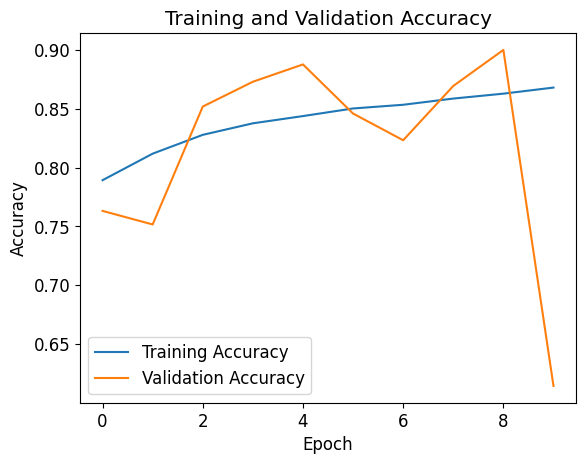

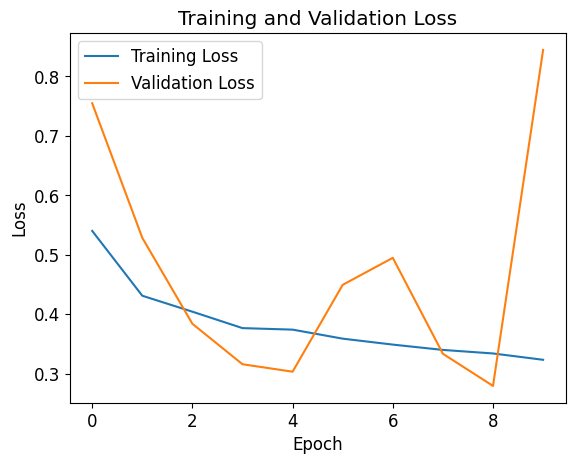

In [ ]:
# Extract accuracy and loss from the history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model to disk
resnet_model.save('resnet_model.h5')

# Check the file size
import os
print("Model size:", os.path.getsize('resnet_model.h5'), "bytes")

import time

# Measure inference time
start_time = time.time()
predictions = resnet_model.predict(validation_generator)
end_time = time.time()

# Calculate average inference time per sample
inference_time_per_sample = (end_time - start_time) / len(validation_generator)

print("Inference time per sample:", inference_time_per_sample, "seconds")

Model size: 317400264 bytes
79/79 [==============================] - 14s 171ms/step
Inference time per sample: 0.1747199915632417 seconds


In [ ]:
# Build the model
Tiny_model = Sequential([
    Input(shape=(150, 150, 3)),  # Input layer for data of shape (150, 150, 3)
    Flatten(),  # Flatten the input image
    Dense(128, activation='relu'),  # Dense layer with 128 units and ReLU activation
    Dense(2, activation='softmax')  # Output layer with 10 units for 10 classes (digits 0-9)
])

# Compile the model
Tiny_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Tiny_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 8640386 (32.96 MB)
Trainable params: 8640386 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = Tiny_model.fit_generator(
    train_generator,  # training data generator
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,  # validation data generator
    validation_steps=len(validation_generator)
)

<ipython-input-6-88e50eaaf6ac>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Tiny_model.fit_generator(


Epoch 1/10
706/706 [==============================] - 142s 199ms/step - loss: 1.0560 - accuracy: 0.7495 - val_loss: 0.4391 - val_accuracy: 0.8217
Epoch 2/10
706/706 [==============================] - 142s 201ms/step - loss: 0.4812 - accuracy: 0.7849 - val_loss: 0.3808 - val_accuracy: 0.8345
Epoch 3/10
706/706 [==============================] - 142s 202ms/step - loss: 0.4712 - accuracy: 0.7872 - val_loss: 0.4746 - val_accuracy: 0.8126
Epoch 4/10
706/706 [==============================] - 143s 202ms/step - loss: 0.4690 - accuracy: 0.7909 - val_loss: 0.4042 - val_accuracy: 0.8532
Epoch 5/10
706/706 [==============================] - 144s 204ms/step - loss: 0.4676 - accuracy: 0.7913 - val_loss: 0.4166 - val_accuracy: 0.8432
Epoch 6/10
706/706 [==============================] - 143s 203ms/step - loss: 0.4662 - accuracy: 0.7922 - val_loss: 0.3914 - val_accuracy: 0.8556
Epoch 7/10
706/706 [==============================] - 143s 203ms/step - loss: 0.4666 - accuracy: 0.7936 - val_loss: 0.4228 -

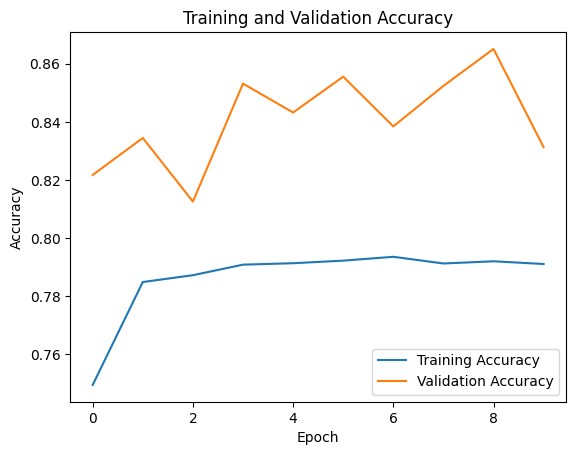

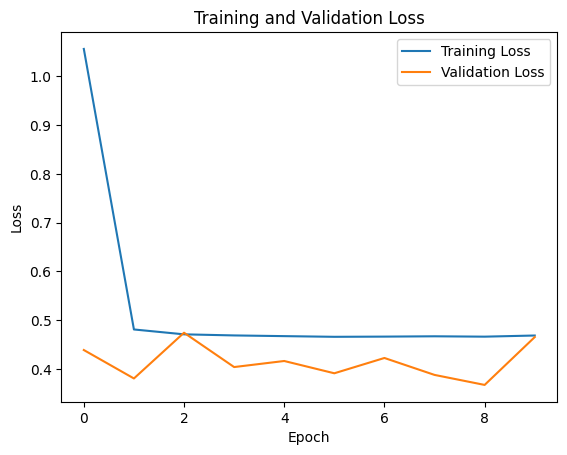

In [ ]:
# Extract accuracy and loss from the history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model to disk
Tiny_model.save('Tiny_model.h5')

# Check the file size
import os
print("Model size:", os.path.getsize('Tiny_model.h5'), "bytes")

import time

# Measure inference time
start_time = time.time()
predictions = Tiny_model.predict(validation_generator)
end_time = time.time()

# Calculate average inference time per sample
inference_time_per_sample = (end_time - start_time) / len(validation_generator)

print("Inference time per sample:", inference_time_per_sample, "seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model size: 103710544 bytes
79/79 [==============================] - 14s 179ms/step
Inference time per sample: 0.1838533999044684 seconds


In [ ]:
train_generator_size64 = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TRAIN',  # path to the training data directory
    target_size=(64, 64),  # resize images to 150x150
    batch_size=32,  # batch size
    class_mode='binary'  # binary classification
)

validation_generator_size64 = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TEST',  # path to the validation data directory
    target_size=(64, 64),  # resize images to 150x150
    batch_size=32,  # batch size
    class_mode='binary'  # binary classification
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
# Load MobileNet model with pre-trained weights
base_model_size64 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add a global average pooling layer
x = base_model_size64.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with 128 neurons
x = Dense(128, activation='relu')(x)

# Add a classification layer with the number of classes in your dataset
predictions = Dense(2, activation='softmax')(x)

# Combine the base model with the new layers
base_model_size64 = Model(inputs=base_model_size64.input, outputs=predictions)

# Compile the model
base_model_size64.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
base_model_size64.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 32, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 32, 32, 32)           0         ['bn_Conv1[0][0]']      

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
base_model_size64.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = base_model_size64.fit_generator(
    train_generator_size64,  # training data generator
    steps_per_epoch=len(train_generator_size64),
    epochs=10,
    validation_data=validation_generator_size64,  # validation data generator
    validation_steps=len(validation_generator_size64)
)

Epoch 1/10


<ipython-input-9-a86c895c7101>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model_size64.fit_generator(
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


706/706 [==============================] - 82s 78ms/step - loss: 0.3702 - accuracy: 0.8528 - val_loss: 5.4828 - val_accuracy: 0.4429
Epoch 2/10
706/706 [==============================] - 53s 75ms/step - loss: 0.2913 - accuracy: 0.8844 - val_loss: 0.8552 - val_accuracy: 0.7656
Epoch 3/10
706/706 [==============================] - 53s 75ms/step - loss: 0.2992 - accuracy: 0.8773 - val_loss: 0.7037 - val_accuracy: 0.8878
Epoch 4/10
706/706 [==============================] - 53s 75ms/step - loss: 0.2730 - accuracy: 0.8915 - val_loss: 0.6737 - val_accuracy: 0.8269
Epoch 5/10
706/706 [==============================] - 52s 74ms/step - loss: 0.2650 - accuracy: 0.8957 - val_loss: 0.5357 - val_accuracy: 0.8599
Epoch 6/10
706/706 [==============================] - 53s 75ms/step - loss: 0.2757 - accuracy: 0.8935 - val_loss: 1.7333 - val_accuracy: 0.6825
Epoch 7/10
706/706 [==============================] - 54s 77ms/step - loss: 0.2843 - accuracy: 0.8852 - val_loss: 0.3900 - val_accuracy: 0.8934
Epo

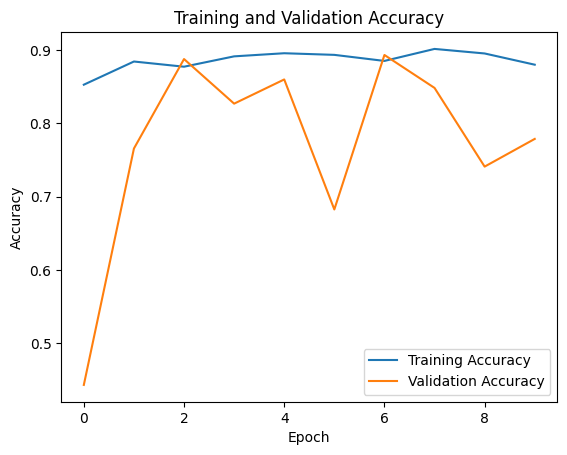

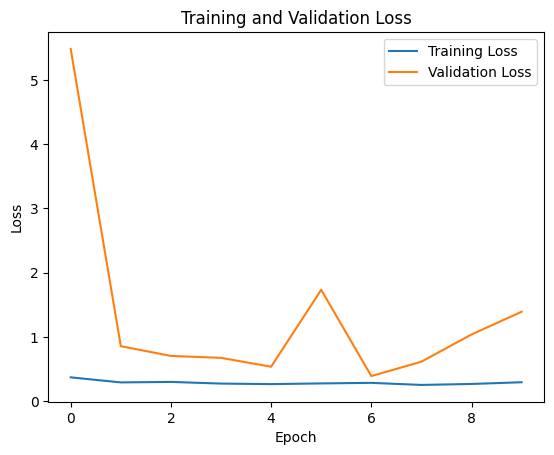

In [ ]:
# Extract accuracy and loss from the history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model to disk
base_model_size64.save('mobile_model_size64.h5')

# Check the file size
import os
print("Model size:", os.path.getsize('mobile_model_size64.h5'), "bytes")

import time

# Measure inference time
start_time = time.time()
predictions = base_model_size64.predict(validation_generator_size64)
end_time = time.time()

# Calculate average inference time per sample
inference_time_per_sample = (end_time - start_time) / len(validation_generator_size64)

print("Inference time per sample:", inference_time_per_sample, "seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model size: 29643072 bytes
79/79 [==============================] - 6s 66ms/step
Inference time per sample: 0.07860827144188216 seconds


In [67]:
train_generator_64 = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TRAIN',  # path to the training data directory
    target_size=(150, 150),  # resize images to 224x224
    batch_size=64,  # batch size
    class_mode='binary'  # binary classification
)

validation_generator_64 = datagen.flow_from_directory(
    '/content/WasteClassification/DATASET/TEST',  # path to the validation data directory
    target_size=(150, 150),  # resize images to 224x224
    batch_size=64,  # batch size
    class_mode='binary'  # binary classification
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
base_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = base_model.fit_generator(
    train_generator_64,  # training data generator
    steps_per_epoch=len(train_generator_64),
    epochs=10,
    validation_data=validation_generator_64,  # validation data generator
    validation_steps=len(validation_generator_64)
)

<ipython-input-6-7488fdbf8e20>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 [==============================] - 191s 462ms/step - loss: 0.2634 - accuracy: 0.8998 - val_loss: 5.0359 - val_accuracy: 0.4827
Epoch 2/10
353/353 [==============================] - 162s 459ms/step - loss: 0.2138 - accuracy: 0.9187 - val_loss: 3.4942 - val_accuracy: 0.4811
Epoch 3/10
353/353 [==============================] - 162s 460ms/step - loss: 0.1991 - accuracy: 0.9249 - val_loss: 3.0511 - val_accuracy: 0.5360
Epoch 4/10
353/353 [==============================] - 162s 460ms/step - loss: 0.1829 - accuracy: 0.9294 - val_loss: 4.1227 - val_accuracy: 0.5253
Epoch 5/10
353/353 [==============================] - 162s 458ms/step - loss: 0.1793 - accuracy: 0.9313 - val_loss: 1.1713 - val_accuracy: 0.7760
Epoch 6/10
353/353 [==============================] - 162s 458ms/step - loss: 0.1747 - accuracy: 0.9333 - val_loss: 0.7469 - val_accuracy: 0.8838
Epoch 7/10
353/353 [==============================] - 164s 465ms/step - loss: 0.1662 - accuracy: 0.9380 - val_loss: 1.8607 - val_accura

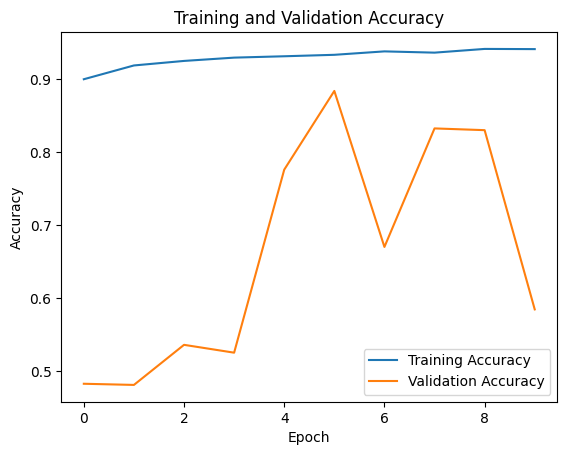

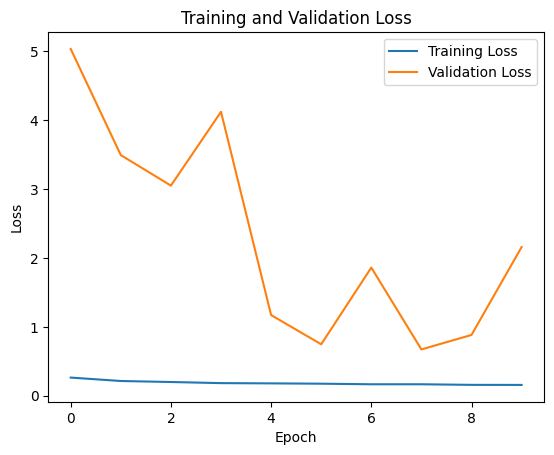

In [ ]:
# Extract accuracy and loss from the history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model to disk
base_model.save('mobile_model_batch64.h5')

# Check the file size
import os
print("Model size:", os.path.getsize('mobile_model_batch64.h5'), "bytes")

import time

# Measure inference time
start_time = time.time()
predictions = base_model.predict(validation_generator_64)
end_time = time.time()

# Calculate average inference time per sample
inference_time_per_sample = (end_time - start_time) / len(validation_generator_64)

print("Inference time per sample:", inference_time_per_sample, "seconds")

Model size: 29643040 bytes
40/40 [==============================] - 17s 398ms/step
Inference time per sample: 0.43276342153549197 seconds


# Model Compression

The next step in our project is to apply model compression techniques to reduce the size of our model, allowing better compatability with edge devices. We will focus on pruning and quantization.

We will test methods of one-shot pruning versus iterative pruning at target sparsities of 10%, 30%, 50% and 80%. Then, we will apply quantization (none, 8-bit and 16-bit). After all this, we will re-evaluate our model and choose the model that yields the best results.

In [33]:
load_model = tf.keras.models.load_model('/content/WasteClassification/mobile_model_batch64.h5', compile=True)

In [39]:
# Convert model from type Functional to Sequential
mobilenet_model = keras.models.Sequential()
for layer in load_model.layers:
    if not isinstance(layer, keras.layers.Add):
        mobilenet_model.add(layer)

In [40]:
mobilenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 Conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 expanded_conv_depthwise (D  (None, 75, 75, 32)        288       
 epthwiseConv2D)                                                 
                                                                 
 expanded_conv_depthwise_BN  (None, 75, 75, 32)        128       
  (BatchNormalization)                                           
                                                      

In [42]:
# Define a function that applies one-shot pruning
def apply_pruning(model, target_sparsity):
  # Prune model with target sparsity
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning. The sparsity is the target sparsity
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity, begin_step=0, frequency=100)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Fine tune the pruned model
  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(
      train_generator,  # training data generator
      steps_per_epoch=len(train_generator),
      epochs=2,
      validation_data=validation_generator,  # validation data generator
      validation_steps=len(validation_generator),
      callbacks=callbacks
  )


  # Strip the pruned model
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  # Save the model
  pruned_model.save('/content/WasteClassification/pruned_'+str(int(target_sparsity*100))+'_model')
  stripped_pruned_model.save('/content/WasteClassification/s_p_'+str(int(target_sparsity*100))+'_model.h5')

  # Print statement to acknowledge a successful execution of code
  print('Model Saved!')

  return None

In [48]:
# Define a function that applies iterative pruning
def iterative_pruning(model, initial_sparsity, final_sparsity, begin_step, end_step):
  # Prune model with target sparsity
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning. The sparsity is the target sparsity
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=100)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Fine tune the pruned model
  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(
      train_generator,  # training data generator
      steps_per_epoch=len(train_generator),
      epochs=2,
      validation_data=validation_generator,  # validation data generator
      validation_steps=len(validation_generator),
      callbacks=callbacks
  )


  # Strip the pruned model
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  # Save model
  pruned_model.save('/content/WasteClassification/iter_pruned_'+str(int(final_sparsity*100))+'_model')
  stripped_pruned_model.save('/content/WasteClassification/iter_s_p_'+str(int(final_sparsity*100))+'_model.h5')

  # Print statement to acknowledge a successful execution of code
  print('Model Saved!')

  return None

In [15]:
# Define a function that applies post-training quantization
def quantization(path=None, quantization_level=8):

  # Load model
  model = tf.keras.models.load_model(path+'.h5')

  # Convert model to TFLite and apply quantization
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT] # Set default optimizer (8-bit quantization)
  converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
  ]
  if quantization_level == 16:
    converter.target_spec.supported_types = [tf.float16] # Apply 16-bit floating point quantization
  quantized_tflite_model = converter.convert() # convert to 8- or 16-bit floating point

  # Save the TFLite model
  with open(path+'_'+str(quantization_level)+'_bit', 'wb') as f:
    f.write(quantized_tflite_model)
  with open(path+'_'+str(quantization_level)+'_bit.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

  return None

In [17]:
# Define a function that evaluates the model and returns the accuracy
def evaluate_model(sparsity):
    # Compile the model manually
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)

    return test_acc

First, apply magnitude pruning

In [46]:
sparsity_levels = [0.2, 0.4, 0.6, 0.8]

for target_sparsity in sparsity_levels:
    # Apply the pruning function with the current target sparsity
    pruned_mobile_model = apply_pruning(mobilenet_model, target_sparsity)

Epoch 1/2


KeyboardInterrupt: 

Next, apply Iterative Pruning

In [45]:
# Initialize variables
batch_size = 64
num_training_images = 22564
epochs = 2

# Compute the number of steps per epoch
steps_per_epoch = num_training_images / batch_size
print(f'Number of Steps per Epoch: {steps_per_epoch}')

# Compute the total number of steps
tot_num_steps = steps_per_epoch * epochs
print(f'Total Number of Steps: {tot_num_steps}')

Number of Steps per Epoch: 352.5625
Total Number of Steps: 705.125


To allow for some training before pruning starts, the begin step will start at 50 and the end step will be 700 to prune and retrain for the majority of the architecture to adapt to the pruning and maintain its performance.

In [49]:
sparsity_levels = [0.2, 0.4, 0.6, 0.8]

for target_sparsity in sparsity_levels:
    # Apply the pruning function with the current target sparsity
    pruned_mobile_model = iterative_pruning(mobilenet_model, 0, target_sparsity, 50, 700)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


706/706 [==============================] - 237s 255ms/step - loss: 0.2562 - accuracy: 0.9006 - val_loss: 0.3546 - val_accuracy: 0.9049
Epoch 2/2
706/706 [==============================] - 177s 251ms/step - loss: 0.2327 - accuracy: 0.9108 - val_loss: 0.8786 - val_accuracy: 0.8241


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved!
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


706/706 [==============================] - 233s 250ms/step - loss: 0.2262 - accuracy: 0.9138 - val_loss: 0.4210 - val_accuracy: 0.9113
Epoch 2/2
706/706 [==============================] - 178s 251ms/step - loss: 0.2134 - accuracy: 0.9192 - val_loss: 0.5133 - val_accuracy: 0.8882


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved!
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


706/706 [==============================] - 226s 250ms/step - loss: 0.2183 - accuracy: 0.9169 - val_loss: 0.6130 - val_accuracy: 0.7907
Epoch 2/2
706/706 [==============================] - 176s 249ms/step - loss: 0.1979 - accuracy: 0.9252 - val_loss: 0.3891 - val_accuracy: 0.8575


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved!
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


706/706 [==============================] - 226s 250ms/step - loss: 0.2107 - accuracy: 0.9204 - val_loss: 0.6099 - val_accuracy: 0.5595
Epoch 2/2
706/706 [==============================] - 175s 248ms/step - loss: 0.2333 - accuracy: 0.9229 - val_loss: 0.3688 - val_accuracy: 0.8583


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved!


Next, we will apply 8-bit and 16-bit quantization to both magnitude pruned and iterative pruned models.

In [51]:
# Apply 8-bit quantization to the models with 4 different levels of magnitude pruning applied
quantization('/content/WasteClassification/s_p_20_model', 8)
quantization('/content/WasteClassification/s_p_40_model', 8)
quantization('/content/WasteClassification/s_p_60_model', 8)
quantization('/content/WasteClassification/s_p_80_model', 8)

In [52]:
# Apply 16-bit quantization to the models with 4 different levels of magnitude pruning applied
quantization('/content/WasteClassification/s_p_20_model', 16)
quantization('/content/WasteClassification/s_p_40_model', 16)
quantization('/content/WasteClassification/s_p_60_model', 16)
quantization('/content/WasteClassification/s_p_80_model', 16)

In [53]:
# Apply 8-bit quantization to the models with 4 different levels of iterative pruning applied
quantization('/content/WasteClassification/iter_s_p_20_model', 8)
quantization('/content/WasteClassification/iter_s_p_40_model', 8)
quantization('/content/WasteClassification/iter_s_p_60_model', 8)
quantization('/content/WasteClassification/iter_s_p_80_model', 8)

In [54]:
# Apply 16-bit quantization to the models with 4 different levels of iterative pruning applied
quantization('/content/WasteClassification/iter_s_p_20_model', 16)
quantization('/content/WasteClassification/iter_s_p_40_model', 16)
quantization('/content/WasteClassification/iter_s_p_60_model', 16)
quantization('/content/WasteClassification/iter_s_p_80_model', 16)

# Model Evaluation

For model evaluation, we will calculate the model accuracy and size for comparison among the several models we have trained including magnitude and iterative pruning, along with 8-bit and 16-bit quantization.

In [121]:
# Load the saved models

# MAGNITUDE PRUNING ------------------------------------------------------------------------
# No quantization
pruned_20_model = tf.keras.models.load_model('/content/WasteClassification/pruned_20_model')
pruned_40_model = tf.keras.models.load_model('/content/WasteClassification/pruned_40_model')
pruned_60_model = tf.keras.models.load_model('/content/WasteClassification/pruned_60_model')
pruned_80_model = tf.keras.models.load_model('/content/WasteClassification/pruned_80_model')

# 8-bit quantization
pruned_20_8_bit = tf.lite.Interpreter('/content/WasteClassification/s_p_20_model_8_bit')
pruned_40_8_bit = tf.lite.Interpreter('/content/WasteClassification/s_p_40_model_8_bit')
pruned_60_8_bit = tf.lite.Interpreter('/content/WasteClassification/s_p_60_model_8_bit')
pruned_80_8_bit = tf.lite.Interpreter('/content/WasteClassification/s_p_80_model_8_bit')

# 16-bit quantization
pruned_20_16_bit = tf.lite.Interpreter('/content/WasteClassification/s_p_20_model_8_bit')
pruned_40_16_bit = tf.lite.Interpreter('/content/WasteClassification/s_p_40_model_8_bit')
pruned_60_16_bit = tf.lite.Interpreter('/content/WasteClassification/s_p_60_model_8_bit')
pruned_80_16_bit = tf.lite.Interpreter('/content/WasteClassification/s_p_80_model_8_bit')

# ITERATIVE PRUNING ------------------------------------------------------------------------
# No quantization
iter_pruned_20_model = tf.keras.models.load_model('/content/WasteClassification/iter_pruned_20_model')
iter_pruned_40_model = tf.keras.models.load_model('/content/WasteClassification/iter_pruned_40_model')
iter_pruned_60_model = tf.keras.models.load_model('/content/WasteClassification/iter_pruned_60_model')
iter_pruned_80_model = tf.keras.models.load_model('/content/WasteClassification/iter_pruned_80_model')

# 8-bit quantization
iter_pruned_20_8_bit = tf.lite.Interpreter('/content/WasteClassification/iter_s_p_20_model_8_bit')
iter_pruned_40_8_bit = tf.lite.Interpreter('/content/WasteClassification/iter_s_p_40_model_8_bit')
iter_pruned_60_8_bit = tf.lite.Interpreter('/content/WasteClassification/iter_s_p_60_model_8_bit')
iter_pruned_80_8_bit = tf.lite.Interpreter('/content/WasteClassification/iter_s_p_80_model_8_bit')

# 16-bit quantization
iter_pruned_20_16_bit = tf.lite.Interpreter('/content/WasteClassification/iter_s_p_20_model_16_bit')
iter_pruned_40_16_bit = tf.lite.Interpreter('/content/WasteClassification/iter_s_p_40_model_16_bit')
iter_pruned_60_16_bit = tf.lite.Interpreter('/content/WasteClassification/iter_s_p_60_model_16_bit')
iter_pruned_80_16_bit = tf.lite.Interpreter('/content/WasteClassification/iter_s_p_80_model_16_bit')

We will be using the validation generator dataset created earlier which consists of 2513 images used for testing.

In [122]:
# Sort the magnitude pruned models into their respective variables (for easier access later on)
models_no_quant = [pruned_20_model,
                   pruned_40_model,
                   pruned_60_model,
                   pruned_80_model]
models_8_bit = [pruned_20_8_bit,
                pruned_40_8_bit,
                pruned_60_8_bit,
                pruned_80_8_bit]
models_16_bit = [pruned_20_16_bit,
                 pruned_40_16_bit,
                 pruned_60_16_bit,
                 pruned_80_16_bit]

# Sort the iterative pruned models into their respective variables (for easier access later on)
iter_models_no_quant = [iter_pruned_20_model,
                        iter_pruned_40_model,
                        iter_pruned_60_model,
                        iter_pruned_80_model]
iter_models_8_bit = [iter_pruned_20_8_bit,
                     iter_pruned_40_8_bit,
                     iter_pruned_60_8_bit,
                     iter_pruned_80_8_bit]
iter_models_16_bit =[iter_pruned_20_16_bit,
                     iter_pruned_40_16_bit,
                     iter_pruned_60_16_bit,
                     iter_pruned_80_16_bit]

In [123]:
# A helper function to evaluate the accuracy of TFLite models using the subset of test data created
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  interpreter.allocate_tensors()

  # Initialize variables to be used
  prediction_index = []
  accurate_count = 0
  i = 0

  # Run predictions on every image in the the first batch (64 images)
  for ele in validation_generator_64[0]:

    if i == 0:
      # The first element in IG_test[0] are the 32 images in the first batch
      for image in ele:
        # Create predictions for all the images in the first batch

        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        value = np.argmax(output()[0])
        prediction_index.append(value)

    if i == 1:
      # The second element in IG_test[0] are the truth labels for the images in the first batch
      pred_idx = 0

      for truth_label in ele:
        idx, = np.where(np.isclose(truth_label, 1)) # Find index of value closest to floating-point

        # Compare prediction results with ground truth labels to calculate accuracy.
        if prediction_index[pred_idx] == idx:
          accurate_count += 1

        pred_idx += 1

    # Update counter to iterate through images, then labels
    i += 1

  # Calculate accuracy
  accuracy = accurate_count * 1.0 / len(prediction_index)

  return accuracy;

In [124]:
# Initialize empty lists to store the accuracies
accuracy_no_quant = []
accuracy_8_bit = []
accuracy_16_bit = []
iter_accuracy_no_quant = []
iter_accuracy_8_bit = []
iter_accuracy_16_bit = []

# Initialize empty lists to store the predictions
y_pred_no_quant = []
y_pred_8_bit = []
y_pred_16_bit = []
iter_y_pred_no_quant = []
iter_y_pred_8_bit = []
iter_y_pred_16_bit = []

In [125]:
# MAGNITUDE PRUNING ----------------------------------------------------------------
print('Magnitude Pruned...')

# Compute accuracy/prediction for magnitude pruning, no quantization
for i in trange(len(models_no_quant)):
  model = models_no_quant[i]
  accuracy_no_quant.append(model.evaluate(validation_generator_64, verbose=0)[1])
  pred = model.predict(validation_generator_64, verbose=0)
  pred = np.argmax(pred, axis=1)
  y_pred_no_quant.append(list(pred))
print('No quantization models -> DONE!\n')

Magnitude Pruned...


  0%|          | 0/4 [00:00<?, ?it/s]

No quantization models -> DONE!



In [126]:
# Compute accuracy/prediction for magnitude pruning, 8-bit quantization
for i in trange(len(models_8_bit)):
  model = models_8_bit[i]
  acc = evaluate_model(model)
  accuracy_8_bit.append(acc)
  y_pred_8_bit.append(pred)
print('8-bit quantization models -> DONE!\n')

  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-123-48927c48b4b1>:37: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx, = np.where(np.isclose(truth_label, 1)) # Find index of value closest to floating-point
<ipython-input-123-48927c48b4b1>:40: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if prediction_index[pred_idx] == idx:


8-bit quantization models -> DONE!



In [127]:
# Compute accuracy/prediction for magnitude pruning, 16-bit quantization
for i in trange(len(models_16_bit)):
  model = models_16_bit[i]
  acc = evaluate_model(model)
  accuracy_16_bit.append(acc)
  y_pred_16_bit.append(pred)
print('16-bit quantization models -> DONE!\n')

  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-123-48927c48b4b1>:37: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx, = np.where(np.isclose(truth_label, 1)) # Find index of value closest to floating-point
<ipython-input-123-48927c48b4b1>:40: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if prediction_index[pred_idx] == idx:


16-bit quantization models -> DONE!



In [128]:
# ITERATIVE PRUNING ----------------------------------------------------------------
print('Iterative Pruned...')

# Compute accuracy/prediction for iterative pruning, no quantization
for i in trange(len(iter_models_no_quant)):
  model = iter_models_no_quant[i]
  iter_accuracy_no_quant.append(model.evaluate(validation_generator_64, verbose=0)[1])
  pred = model.predict(validation_generator_64, verbose=0)
  pred = np.argmax(pred,axis=1)
  iter_y_pred_no_quant.append(list(pred))
print('No quantization models -> DONE!\n')

Iterative Pruned...


  0%|          | 0/4 [00:00<?, ?it/s]

No quantization models -> DONE!



In [129]:
# Compute accuracy/prediction for iterative pruning, 8-bit quantization
for i in trange(len(iter_models_8_bit)):
  model = iter_models_8_bit[i]
  acc = evaluate_model(model)
  iter_accuracy_8_bit.append(acc)
  iter_y_pred_8_bit.append(pred)
print('8-bit quantization models -> DONE!\n')

  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-123-48927c48b4b1>:37: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx, = np.where(np.isclose(truth_label, 1)) # Find index of value closest to floating-point
<ipython-input-123-48927c48b4b1>:40: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if prediction_index[pred_idx] == idx:


8-bit quantization models -> DONE!



In [130]:
# Compute accuracy/prediction for iterative pruning, 16-bit quantization
for i in trange(len(iter_models_16_bit)):
  model = iter_models_16_bit[i]
  acc = evaluate_model(model)
  iter_accuracy_16_bit.append(acc)
  iter_y_pred_16_bit.append(pred)
print('16-bit quantization models -> DONE!\n')

  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-123-48927c48b4b1>:37: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx, = np.where(np.isclose(truth_label, 1)) # Find index of value closest to floating-point
<ipython-input-123-48927c48b4b1>:40: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if prediction_index[pred_idx] == idx:


16-bit quantization models -> DONE!



Getting model size

In [107]:
# A helper function to calculate the size of the model
def get_gzipped_model_size(file):

  # Open zip file
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  # Return size of gzipped model, in bytes
  return os.path.getsize(zipped_file)

In [112]:
# Store/group paths in lists for easier access
paths_no_quant = ['/content/WasteClassification/s_p_20_model.h5',\
                  '/content/WasteClassification/s_p_40_model.h5',\
                  '/content/WasteClassification/s_p_60_model.h5',\
                  '/content/WasteClassification/s_p_80_model.h5']
paths_8_bit = ['/content/WasteClassification/s_p_20_model_8_bit.tflite',\
               '/content/WasteClassification/s_p_40_model_8_bit.tflite',\
               '/content/WasteClassification/s_p_60_model_8_bit.tflite',\
               '/content/WasteClassification/s_p_80_model_8_bit.tflite']
paths_16_bit = ['/content/WasteClassification/s_p_20_model_16_bit.tflite',\
                '/content/WasteClassification/s_p_40_model_16_bit.tflite',\
                '/content/WasteClassification/s_p_60_model_16_bit.tflite',\
                '/content/WasteClassification/s_p_80_model_16_bit.tflite']
iter_paths_no_quant = ['/content/WasteClassification/iter_s_p_20_model.h5',\
                  '/content/WasteClassification/iter_s_p_40_model.h5',\
                  '/content/WasteClassification/iter_s_p_60_model.h5',\
                  '/content/WasteClassification/iter_s_p_80_model.h5']
iter_paths_8_bit = ['/content/WasteClassification/iter_s_p_20_model_8_bit.tflite',\
               '/content/WasteClassification/iter_s_p_40_model_8_bit.tflite',\
               '/content/WasteClassification/iter_s_p_60_model_8_bit.tflite',\
               '/content/WasteClassification/iter_s_p_80_model_8_bit.tflite']
iter_paths_16_bit = ['/content/WasteClassification/iter_s_p_20_model_16_bit.tflite',\
                '/content/WasteClassification/iter_s_p_40_model_16_bit.tflite',\
                '/content/WasteClassification/iter_s_p_60_model_16_bit.tflite',\
                '/content/WasteClassification/iter_s_p_80_model_16_bit.tflite']

In [110]:
# Initialize empty lists to store the model sizes computed
size_no_quant = []
size_8_bit = []
size_16_bit = []
iter_size_no_quant = []
iter_size_8_bit = []
iter_size_16_bit = []

In [113]:
# MAGNITUDE PRUNING ----------------------------------------------------------------
print('Magnitude Pruned')

# Calculate the model size for magnitude pruning, no quantization
counter = 1
for i in trange(len(models_no_quant)):
  path = paths_no_quant[i]
  size_no_quant.append(get_gzipped_model_size(path))
  counter += 1
print('No quantization models -> DONE!\n')

# Calculate the model size for magnitude pruning, 8-bit quantization
counter = 1
for i in trange(len(models_8_bit)):
  path = paths_8_bit[i]
  size_8_bit.append(get_gzipped_model_size(path))
  counter += 1
print('8-bit quantization models -> DONE!\n')

# Calculate the model size for magnitude pruning, 16-bit quantization
counter = 1
for i in trange(len(models_16_bit)):
  path = paths_16_bit[i]
  size_16_bit.append(get_gzipped_model_size(path))
  counter += 1
print('16-bit quantization models -> DONE!\n')

Magnitude Pruned


  0%|          | 0/4 [00:00<?, ?it/s]

No quantization models -> DONE!



  0%|          | 0/4 [00:00<?, ?it/s]

8-bit quantization models -> DONE!



  0%|          | 0/4 [00:00<?, ?it/s]

16-bit quantization models -> DONE!



In [114]:
# ITERATIVE PRUNING ----------------------------------------------------------------
print('Iteratively Pruned...')

# Calculate the model size for iterative pruning, no quantization
counter = 1
for i in trange(len(iter_models_no_quant)):
  path = iter_paths_no_quant[i]
  iter_size_no_quant.append(get_gzipped_model_size(path))
  counter += 1
print('No quantization models -> DONE!\n')

# Calculate the model size for iterative pruning, 8-bit quantization
counter = 1
for i in trange(len(iter_models_8_bit)):
  path = iter_paths_8_bit[i]
  iter_size_8_bit.append(get_gzipped_model_size(path))
  counter += 1
print('8-bit quantization models -> DONE!\n')

# Calculate the model size for iterative pruning, 16-bit quantization
counter = 1
for i in trange(len(iter_models_16_bit)):
  path = iter_paths_16_bit[i]
  iter_size_16_bit.append(get_gzipped_model_size(path))
  counter += 1
print('16-bit quantization models -> DONE!\n')

Iteratively Pruned...


  0%|          | 0/4 [00:00<?, ?it/s]

No quantization models -> DONE!



  0%|          | 0/4 [00:00<?, ?it/s]

8-bit quantization models -> DONE!



  0%|          | 0/4 [00:00<?, ?it/s]

16-bit quantization models -> DONE!



Evaluation

In [105]:
# A helper function to add custom labels to points
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [132]:
# Put labels in a list
name = ['Mag/20%/None', 'Mag/40%/None', 'Mag/60%/None', 'Mag/80%/None',\
         'Mag/20%/8bit', 'Mag/40%/8bit', 'Mag/60%/8bit', 'Mag/80%/8bit',\
         'Mag/20%/16bit', 'Mag/40%/16bit', 'Mag/60%/16bit', 'Mag/80%/16bit',\
         'Ite/20%/None', 'Ite/40%/None', 'Ite/60%/None', 'Ite/80%/None',\
         'Ite/20%/8bit', 'Ite/40%/8bit', 'Ite/60%/8bit', 'Ite/80%/8bit',\
         'Ite/20%/16bit', 'Ite/40%/16bit', 'Ite/60%/16bit', 'Ite/80%/16bit']

# Aggregate data for model accuracy and size
accuracy = accuracy_no_quant + accuracy_8_bit + accuracy_16_bit + iter_accuracy_no_quant + iter_accuracy_8_bit + iter_accuracy_16_bit
size = size_no_quant + size_8_bit + size_16_bit + iter_size_no_quant + iter_size_8_bit + iter_size_16_bit

# Convert metrics to appropriate units
accuracy = [x*100 for x in accuracy]
size = [x/1000 for x in size]

# Define sparsity used for each model (to be used later in the code)
sparsity = [20, 40, 60, 80,
            20, 40, 60, 80,
            20, 40, 60, 80,
            20, 40, 60, 80,
            20, 40, 60, 80,
            20, 40, 60, 80,]

# Put data into a pandas dataframe
df = pd.DataFrame({'Names': name, 'Accuracy (%)': accuracy, 'Model Size (KB)': size, 'Sparsity (%)': sparsity})

# Have a table may also be useful, so we will also print our DataFrame
from tabulate import tabulate
df2 = df.drop(columns=['Sparsity (%)'])
print(tabulate(df2, headers='keys', tablefmt='psql'))

+----+---------------+----------------+-------------------+
|    | Names         |   Accuracy (%) |   Model Size (KB) |
|----+---------------+----------------+-------------------|
|  0 | Mag/20%/None  |        65.1015 |           7939.13 |
|  1 | Mag/40%/None  |        80.6208 |           6533.49 |
|  2 | Mag/60%/None  |        91.922  |           4983.31 |
|  3 | Mag/80%/None  |        78.7903 |           3262.81 |
|  4 | Mag/20%/8bit  |         1.5625 |           2172.56 |
|  5 | Mag/40%/8bit  |        21.875  |           1922.19 |
|  6 | Mag/60%/8bit  |         3.125  |           1532.9  |
|  7 | Mag/80%/8bit  |        20.3125 |           1015.96 |
|  8 | Mag/20%/16bit |         1.5625 |           4052.76 |
|  9 | Mag/40%/16bit |        20.3125 |           3443.95 |
| 10 | Mag/60%/16bit |         3.125  |           2708.21 |
| 11 | Mag/80%/16bit |        23.4375 |           1826.43 |
| 12 | Ite/20%/None  |        83.3665 |           7791.32 |
| 13 | Ite/40%/None  |        89.4548 | 

From the model evaluations, we found that the model that yielded that best accuracy with a relatively small model size is applying magnitude pruning with a target sparsity of 60% and no quantization.